In [1]:
import argparse
import os
import numpy as np
import math
import sys


import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from Tools import NNE, KL

import matplotlib.cm as cm



In [2]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device

device(type='cpu')

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim,samples_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(1., inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 50, normalize=False),
            nn.Linear(50, samples_dim)
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [4]:

class Discriminator(nn.Module):
    def __init__(self, samples_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(samples_dim, 20),
            #nn.LeakyReLU(.1, inplace=True),
           # nn.Linear(50, 50),
            nn.LeakyReLU(.1, inplace=True),
            nn.Linear(20, 1)
        )

    def forward(self, X, y):
        pair=torch.cat([X,y],dim=1)
        validity =2.*torch.sigmoid(self.model(pair))-1.
        #validity =torch.sin(self.model(pair))
        #validity =self.model(pair)
        return validity

In [5]:
def compute_norm_penalty(D, real_X, real_y, fake_X, fake_y):
    """Calculates the norm penalty loss for RGAN"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((1)))
    # Get random interpolation between real and fake samples
    interpolates_X = (alpha * real_X + ((1 - alpha) * fake_X))
    interpolates_y = (alpha * real_y + ((1 - alpha) * fake_y))
    d_interpolates = D(interpolates_X, interpolates_y)
    
    norm_penalty = (d_interpolates.norm(2, dim=1)-1.).mean()
    
    return norm_penalty

def compute_gradient_penalty(discriminator, real_X, real_y, fake_X, fake_y):
    batch_size=real_X.shape[0]
    eta = torch.FloatTensor(batch_size,1).uniform_(0,1)
    eta_X = eta.expand(batch_size, real_X.size(1)).to(device)
    eta_y =  eta.expand(batch_size, real_y.size(1)).to(device)
    interpolated_X = (eta_X * real_X + ((1 - eta_X) * fake_X)).requires_grad_(True)
    interpolated_y = (eta_y * real_y + ((1 - eta_y) * fake_y)).requires_grad_(True)

    # calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated_X,interpolated_y)

    # calculate gradients of probabilities with respect to examples
    gradients_X = autograd.grad(outputs=prob_interpolated, inputs=interpolated_X,
                           grad_outputs=torch.ones(
                               prob_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]
    gradients_y = autograd.grad(outputs=prob_interpolated, inputs=interpolated_y,
                           grad_outputs=torch.ones(
                               prob_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    grad_penalty_X = ((gradients_X.norm(2, dim=1) - 1) ** 2).mean()
    grad_penalty_y = ((gradients_y.norm(2, dim=1) - 1) ** 2).mean()
    return grad_penalty_X, grad_penalty_y

# Data #

In [6]:
from Experiments.foong import Setup
layerwidth=50
nblayers=1
input_dim=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)


In [7]:
X_train, y_train=setup.train_data()
param_count=setup.param_count
model=setup._model
prediction=setup.prediction
projection=setup.projection

X_train.shape, y_train.shape

(torch.Size([200, 1]), torch.Size([200, 1]))

In [8]:
lat_dim=2
samples_dim=param_count

# Initialize generator and discriminator
generator = Generator(lat_dim,samples_dim)
discriminator = Discriminator(input_dim+1)


if cuda:
    generator.cuda()
    discriminator.cuda()
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)

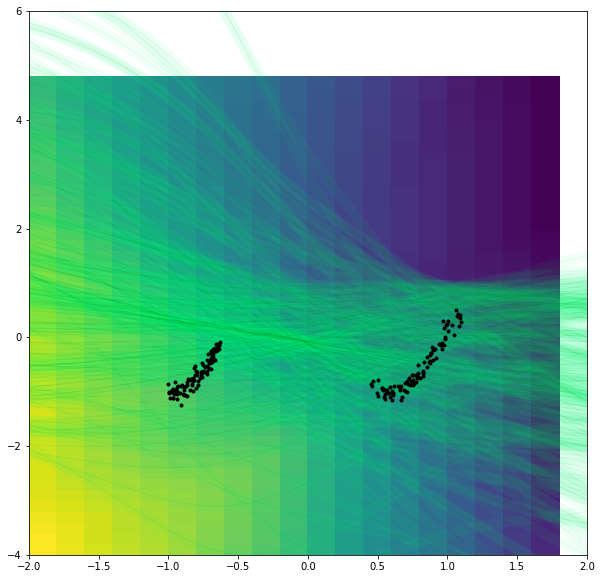

In [9]:
%matplotlib inline
def show(generator,discriminator,n,fake_X=None,fake_y=None):
    z = Tensor(np.random.normal(0, 1, (n, lat_dim)))
    theta=generator(z)

    fig=setup.makePlot(theta,device)
    plt.draw()
    
    x=torch.arange(-2.,2., 0.2).to(device)
    y=torch.arange(-4.,5., 0.2).to(device)
    
    grid_X,grid_Y=torch.meshgrid(x, y)
    D=torch.Tensor(grid_X.shape)

    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            D[i,j]=discriminator(grid_X[i,j].unsqueeze(0).unsqueeze(1), grid_Y[i,j].unsqueeze(0).unsqueeze(1)).cpu()

    cmap = cm.viridis

    
    plt.pcolormesh(grid_X.cpu(),grid_Y.cpu(),D.detach().cpu(),cmap=cmap)
    
    plt.scatter(fake_X,fake_y, color='red')
    plt.draw()
    plt.show()
    return

show(generator,discriminator, 200)

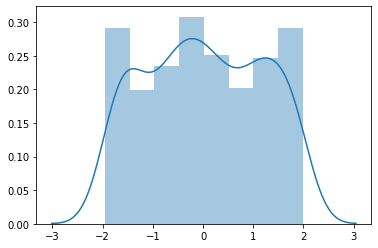

In [10]:
X_input=Tensor(-2.+4.*np.random.random((500, 1, 1, 1)))

sns.distplot(X_input.cpu())

In [11]:
b1=0.5 #0.5
b2=0.9999
lr_g=0.0001
lr_d=0.001
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(b1, b2))





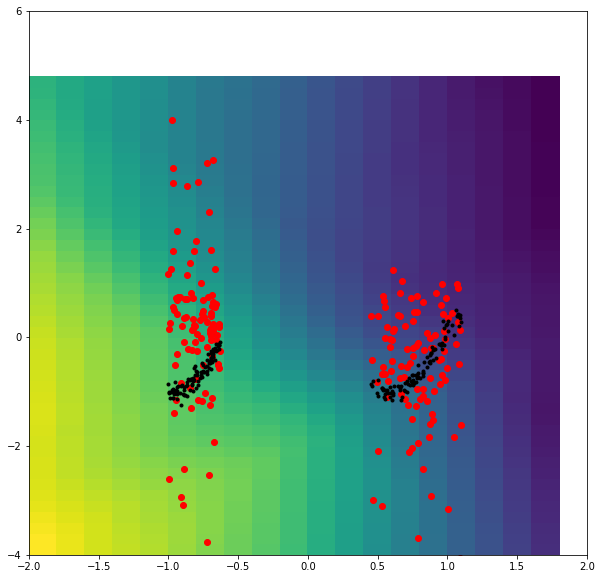

[Epoch 0/20000] [D loss: 0.139231] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


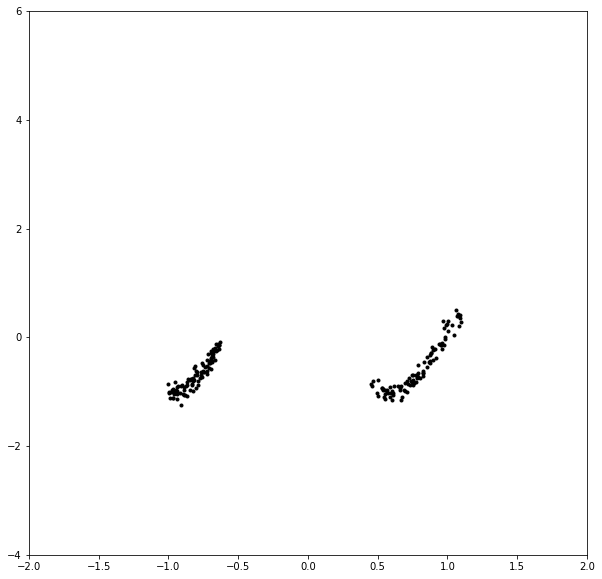

[Epoch 1/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


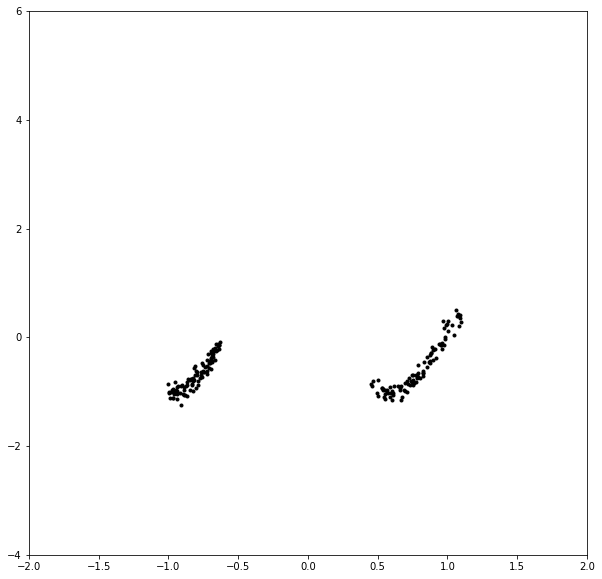

[Epoch 2/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


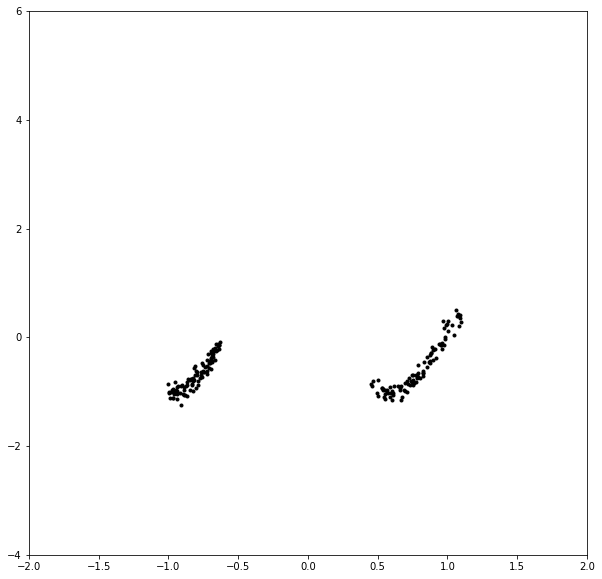

[Epoch 3/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


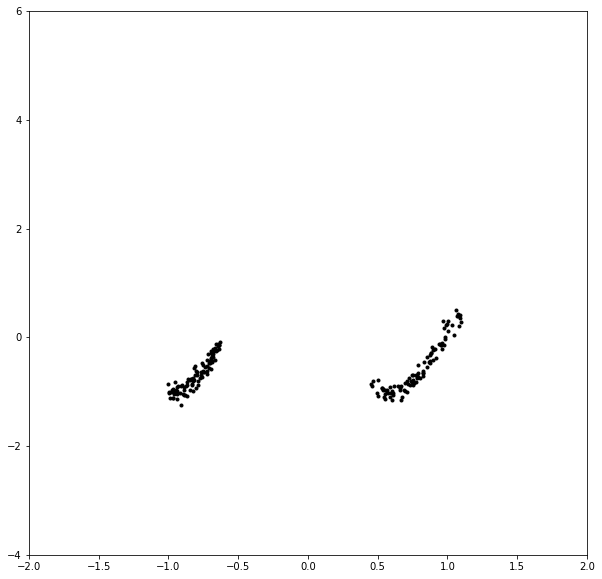

[Epoch 4/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


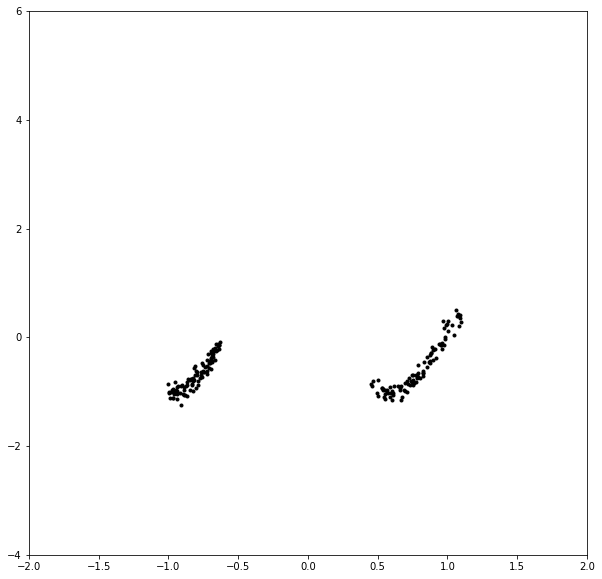

[Epoch 5/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


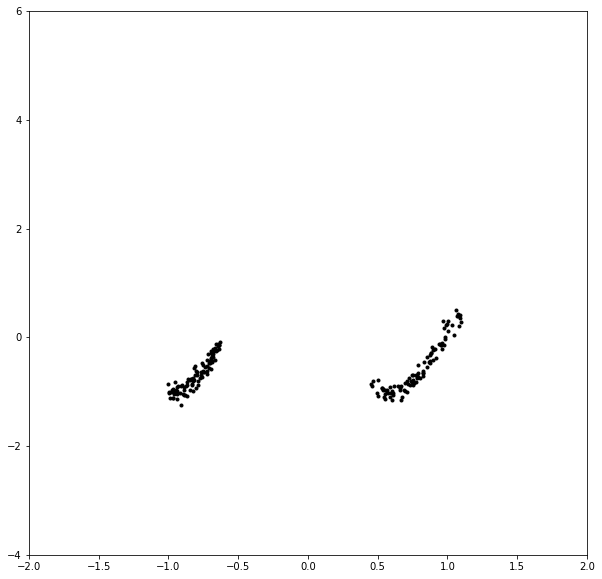

[Epoch 6/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


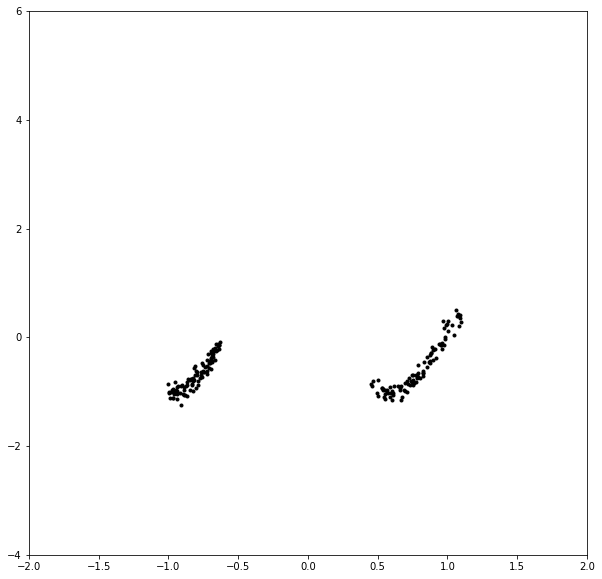

[Epoch 7/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


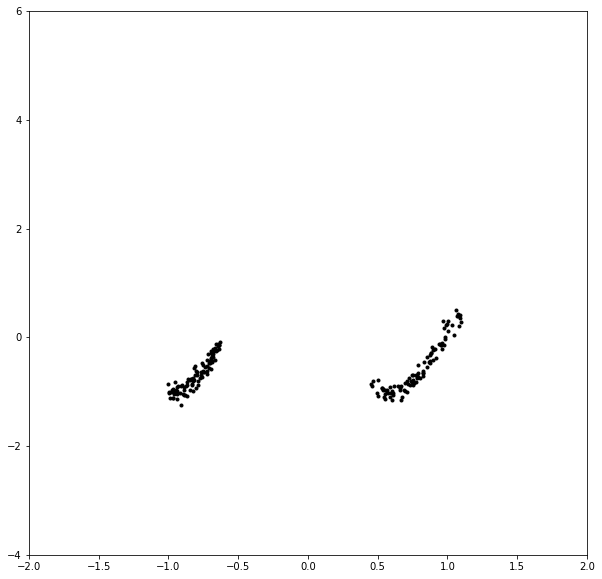

[Epoch 8/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


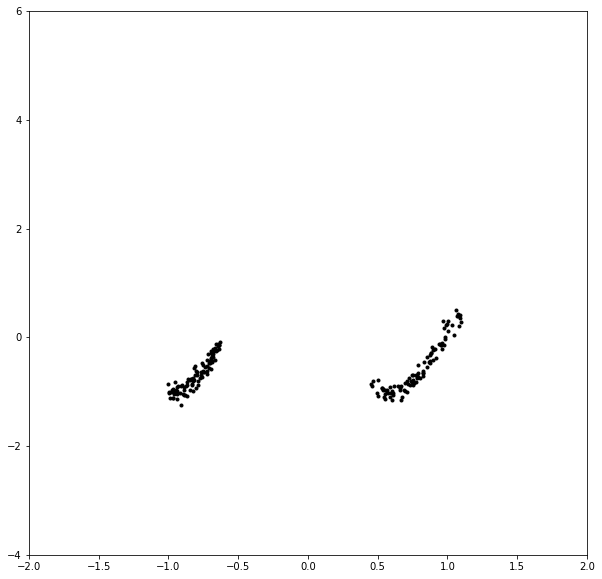

[Epoch 9/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


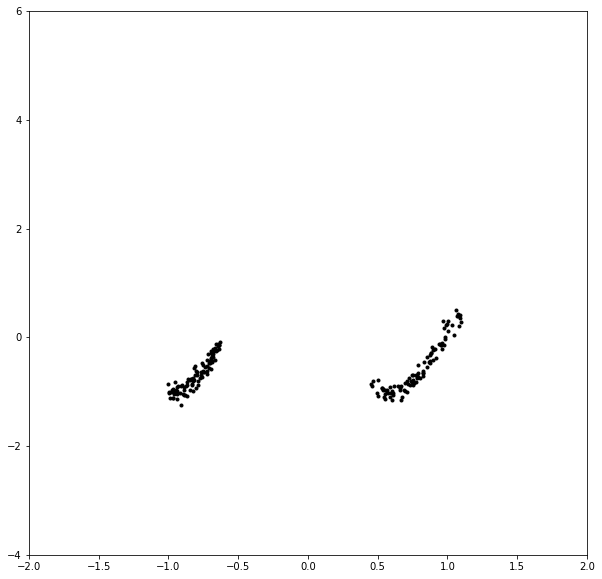

[Epoch 10/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


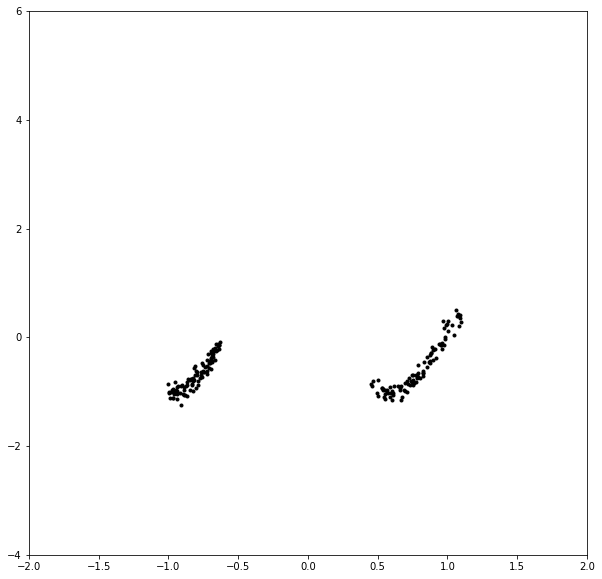

[Epoch 11/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


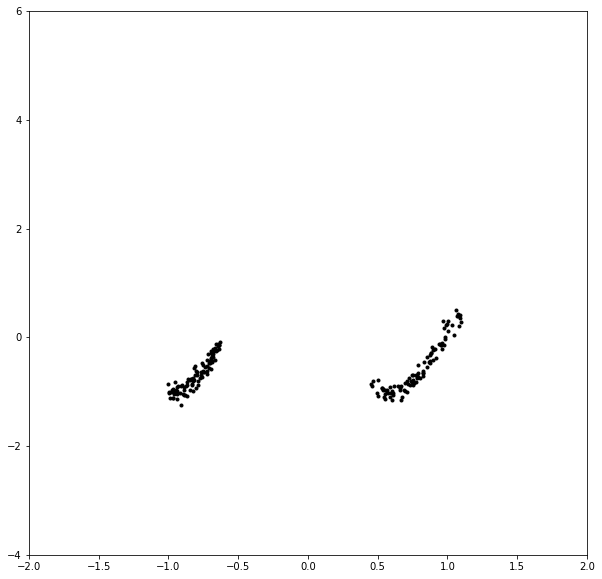

[Epoch 12/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


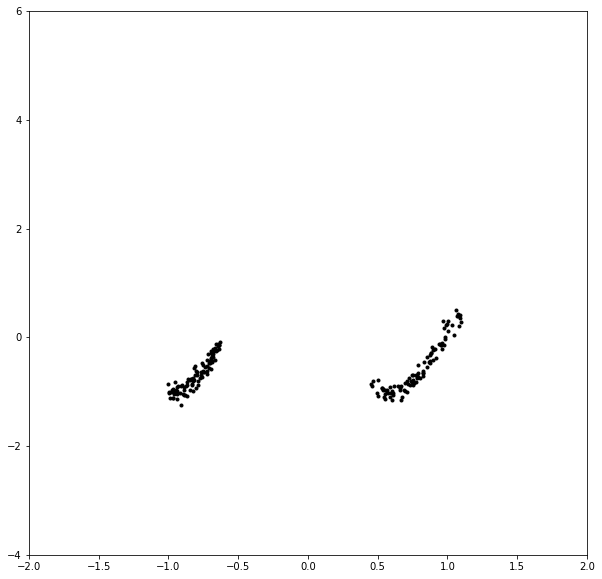

[Epoch 13/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


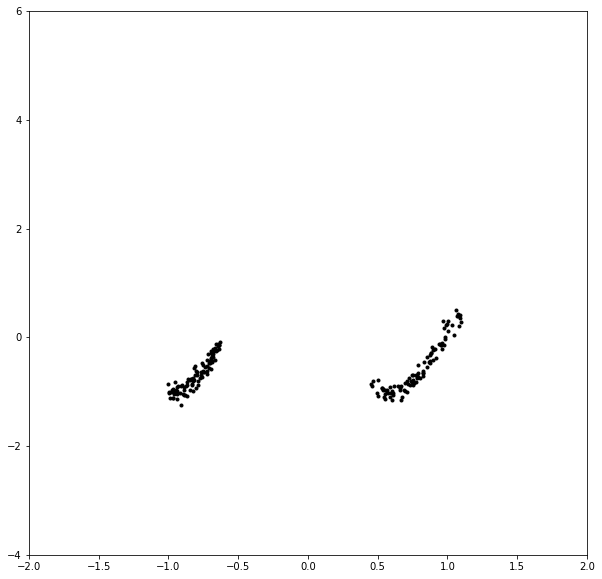

[Epoch 14/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


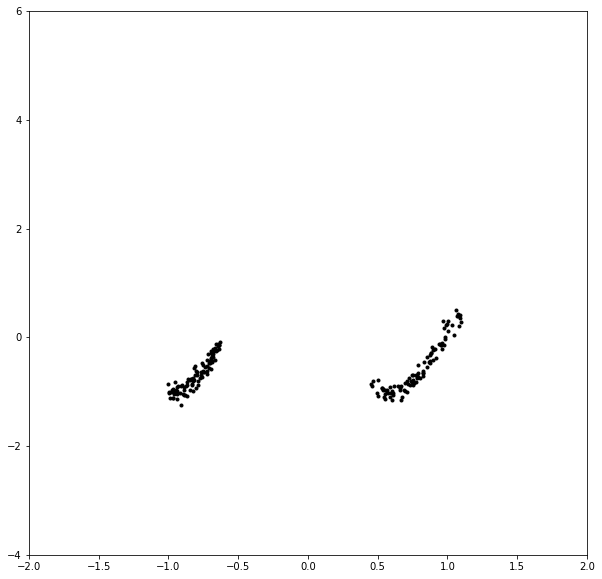

[Epoch 15/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


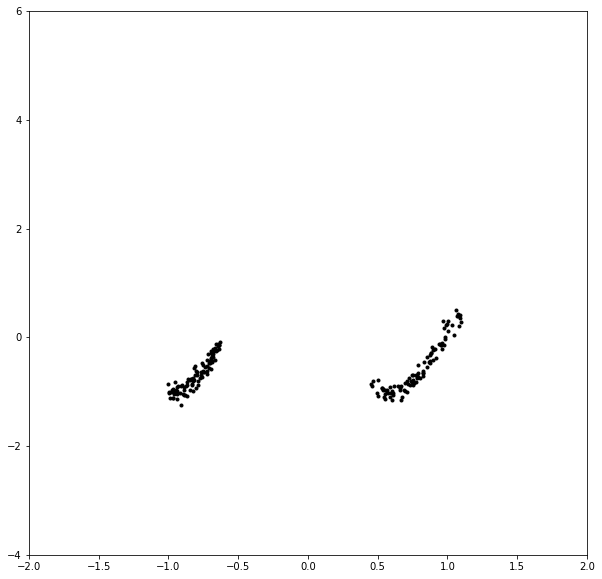

[Epoch 16/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


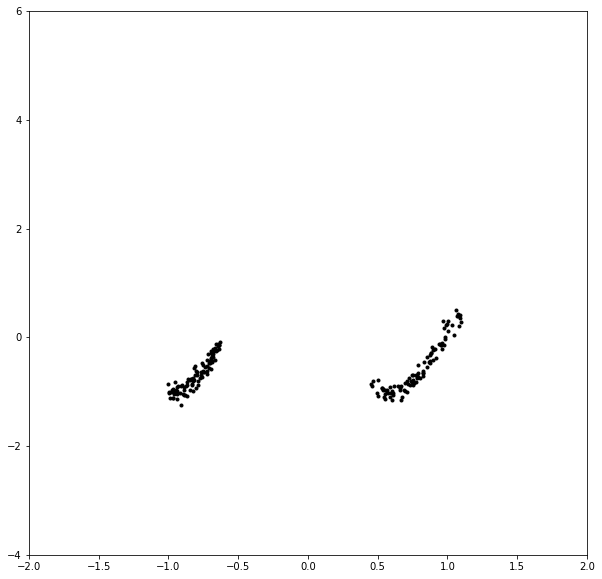

[Epoch 17/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


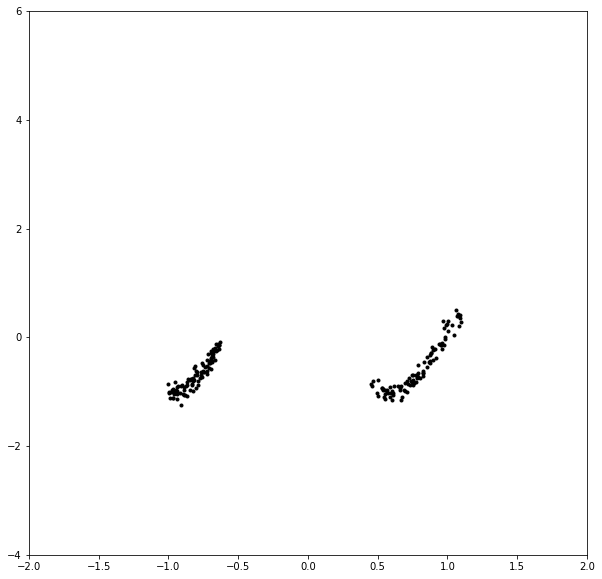

[Epoch 18/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


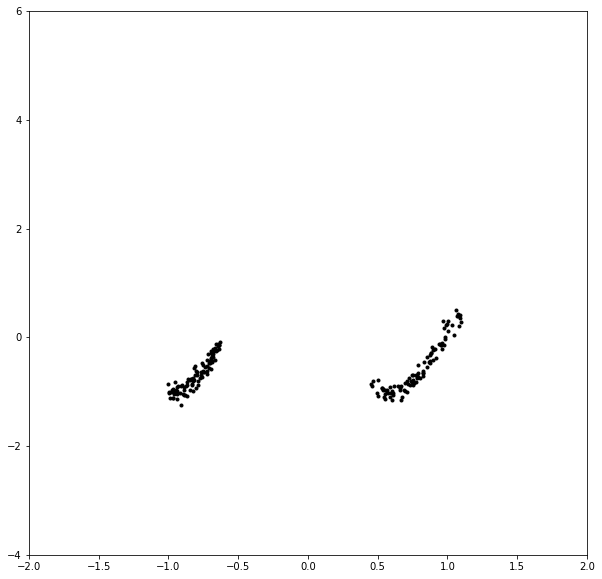

[Epoch 19/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


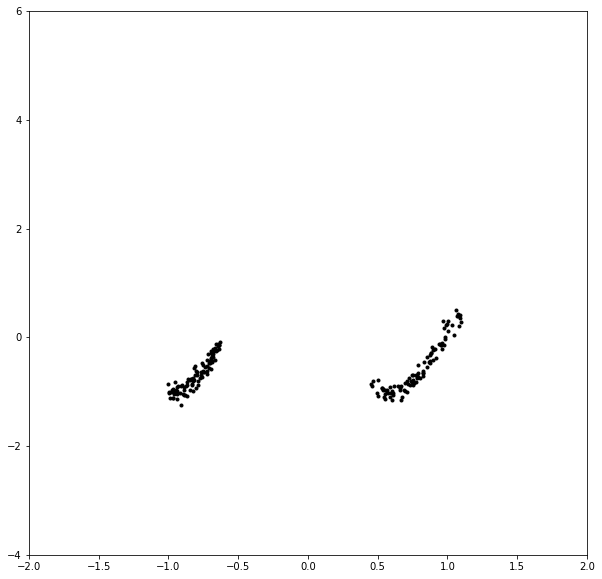

[Epoch 20/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


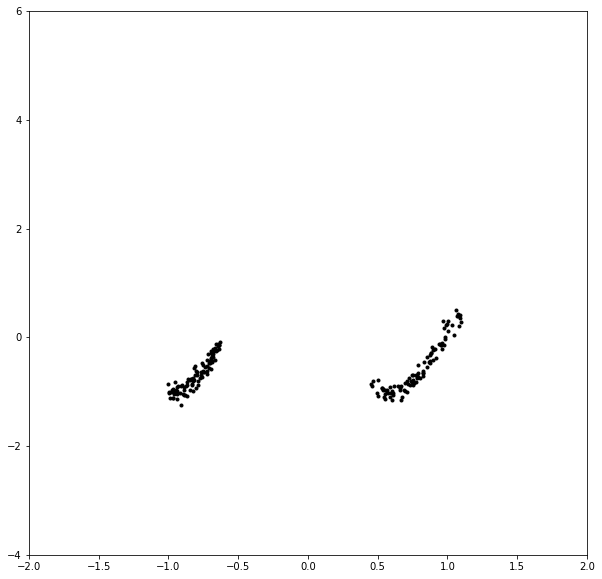

[Epoch 21/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


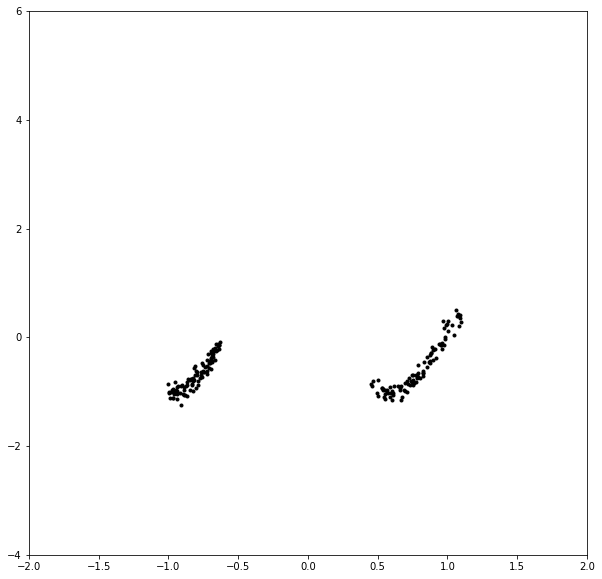

[Epoch 22/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


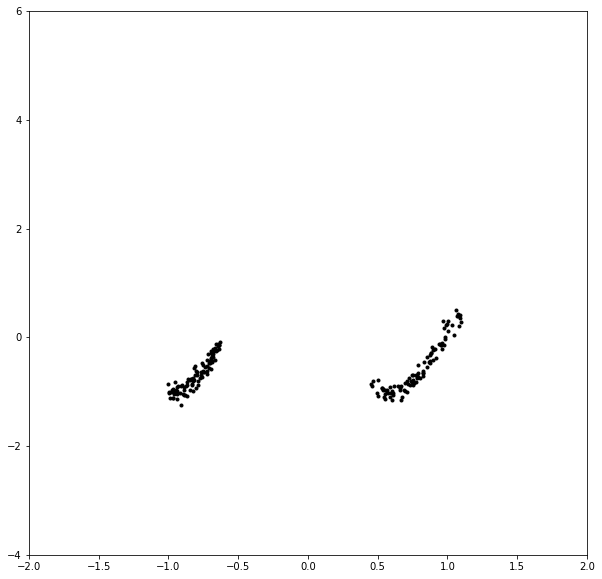

[Epoch 23/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


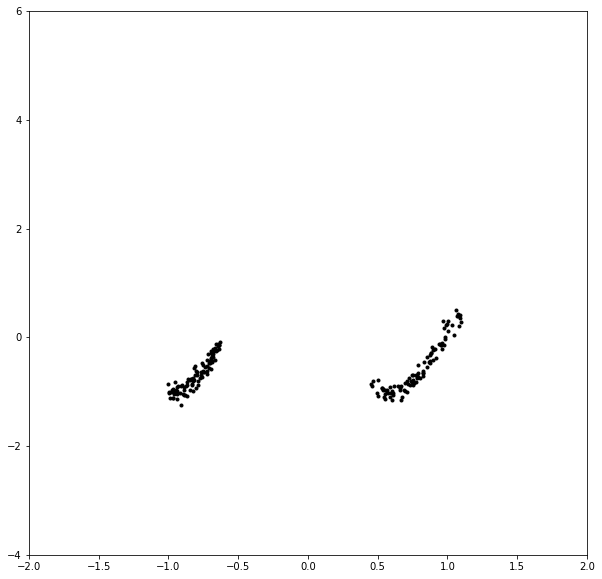

[Epoch 24/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


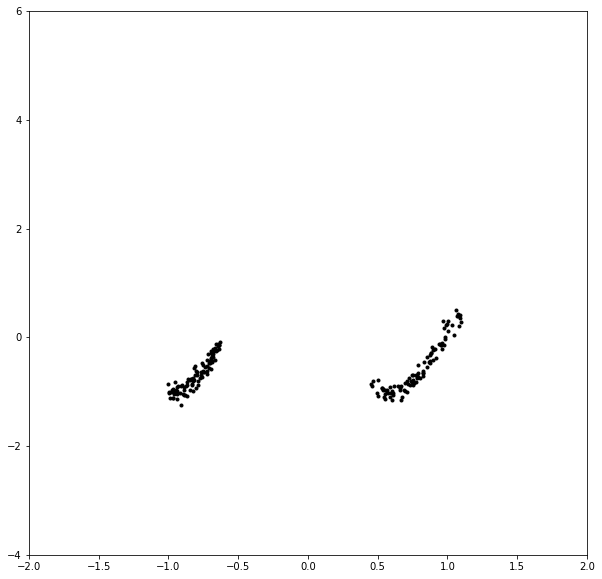

[Epoch 25/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


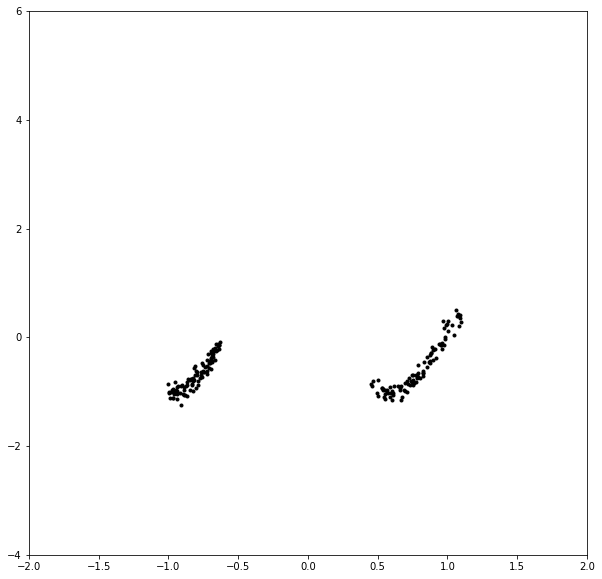

[Epoch 26/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


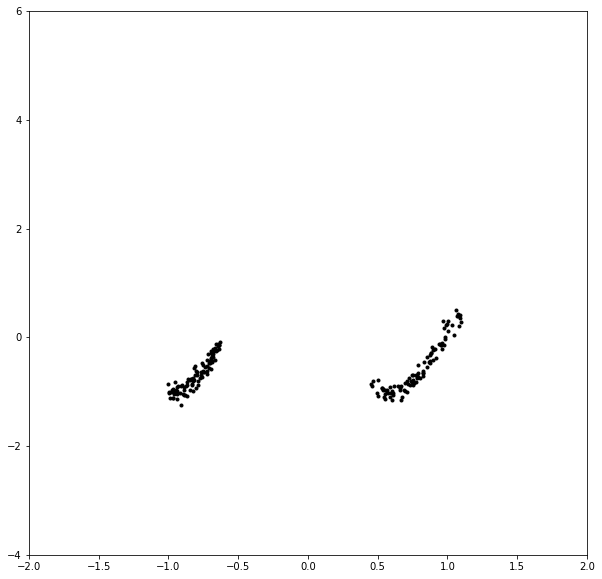

[Epoch 27/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


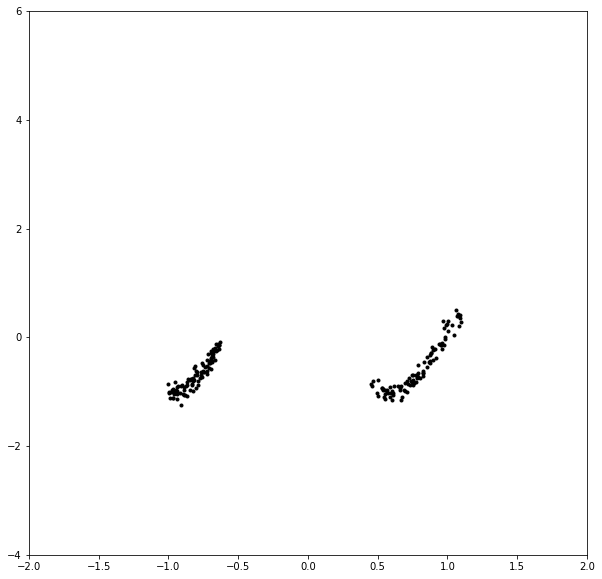

[Epoch 28/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


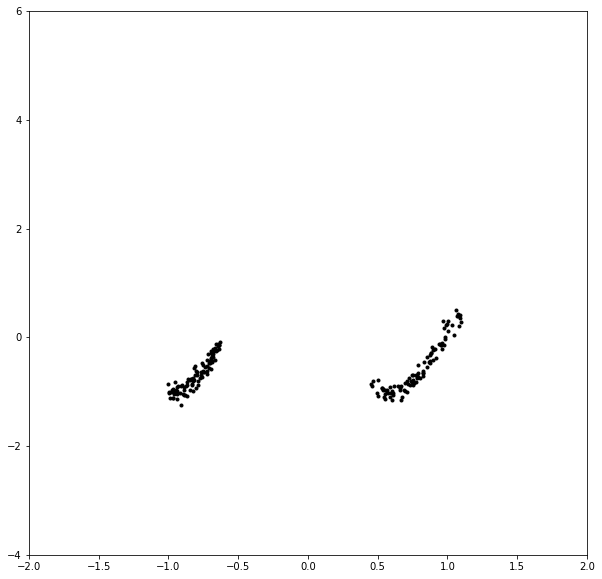

[Epoch 29/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


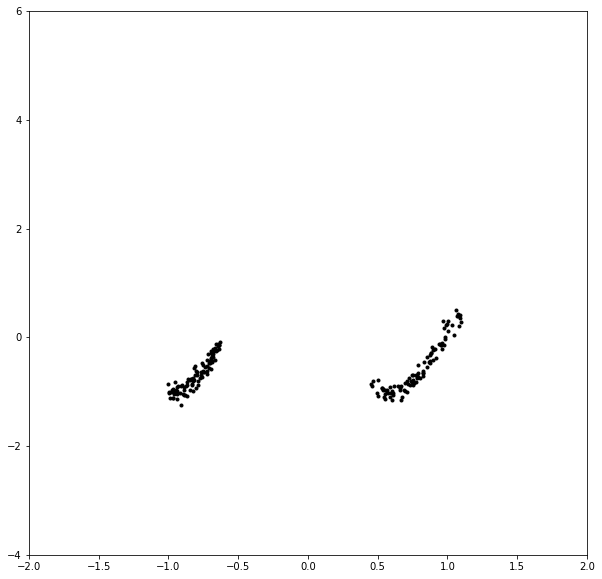

[Epoch 30/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


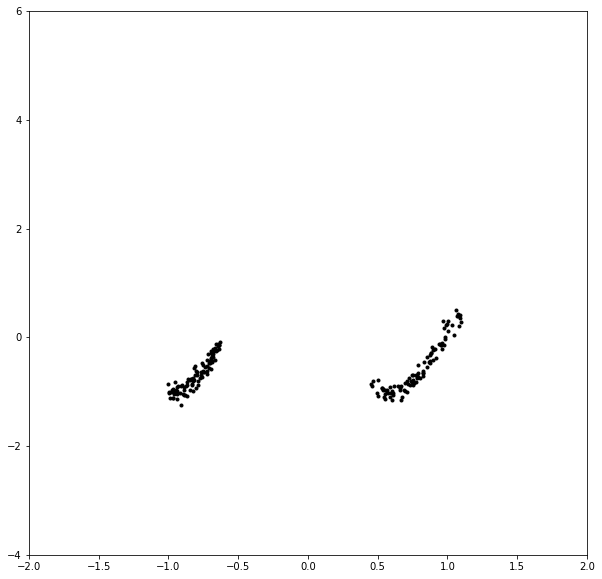

[Epoch 31/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


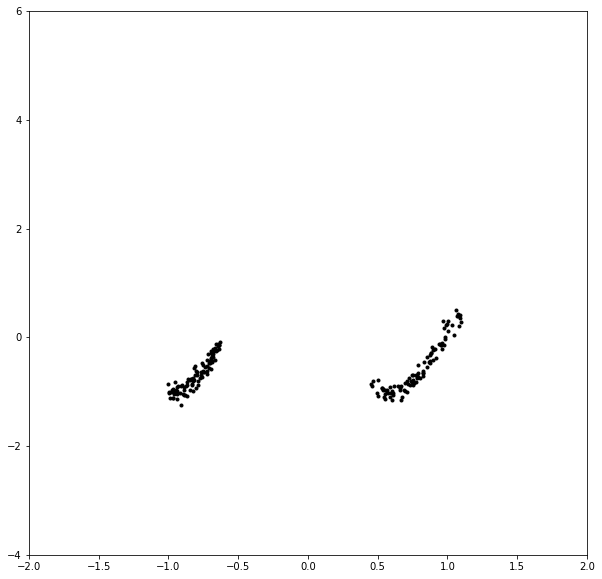

[Epoch 32/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


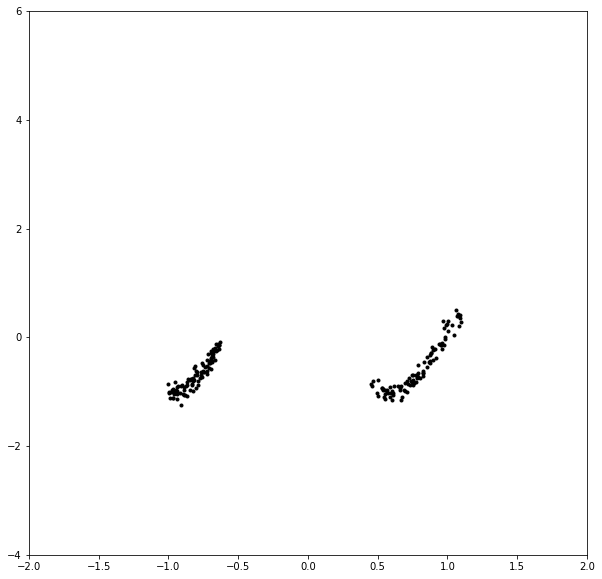

[Epoch 33/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


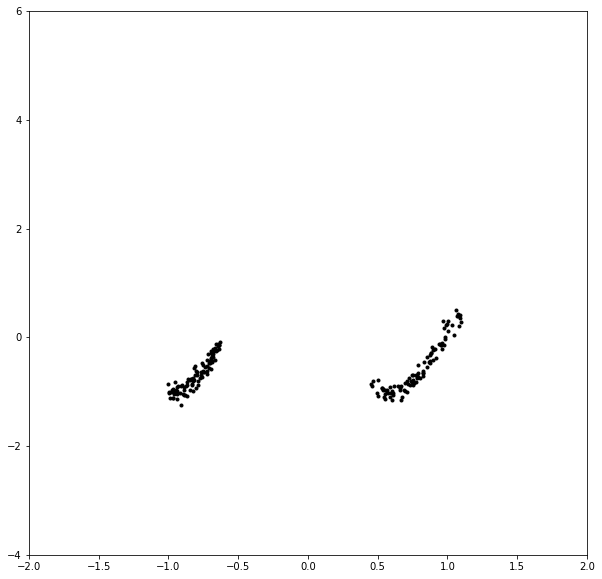

[Epoch 34/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


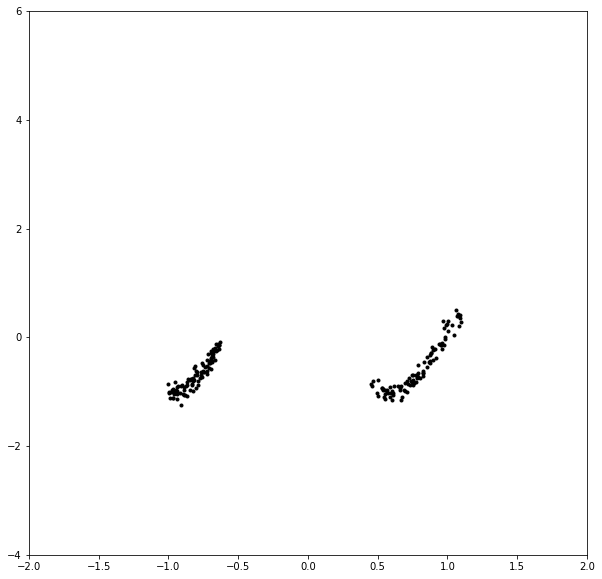

[Epoch 35/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


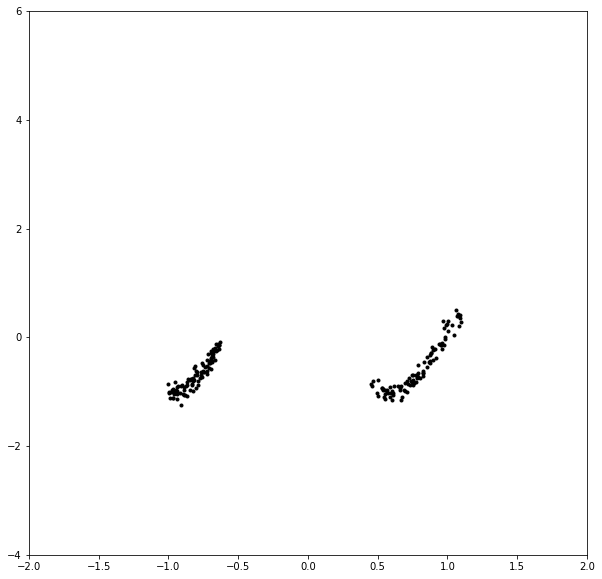

[Epoch 36/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


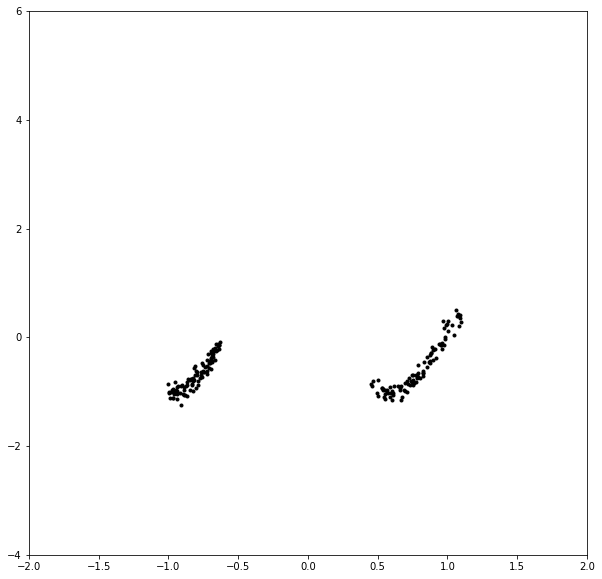

[Epoch 37/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


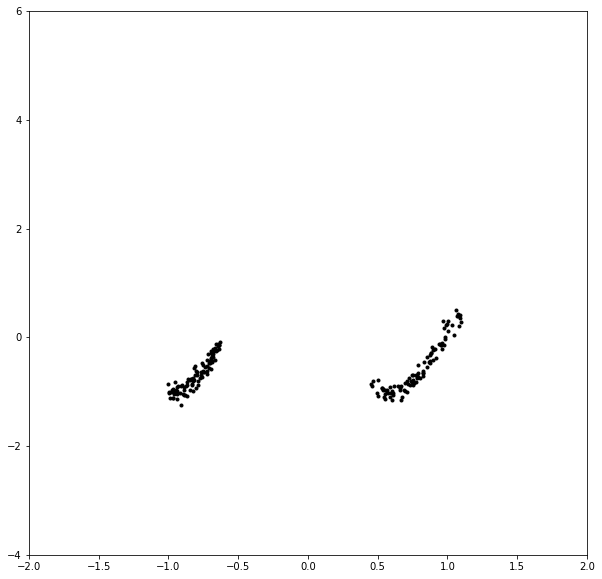

[Epoch 38/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


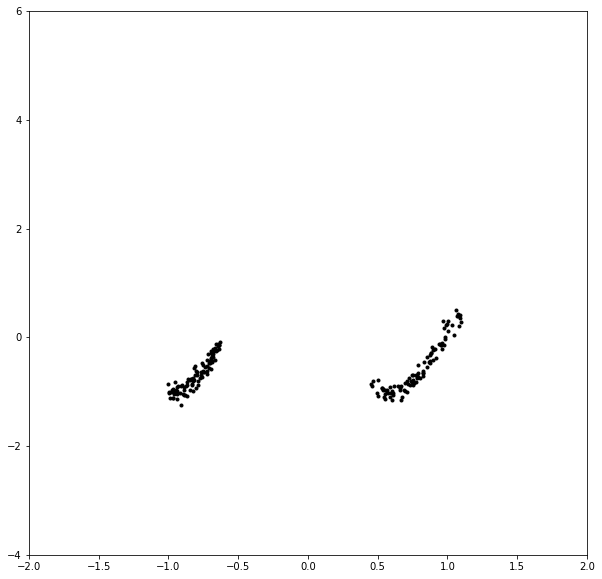

[Epoch 39/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


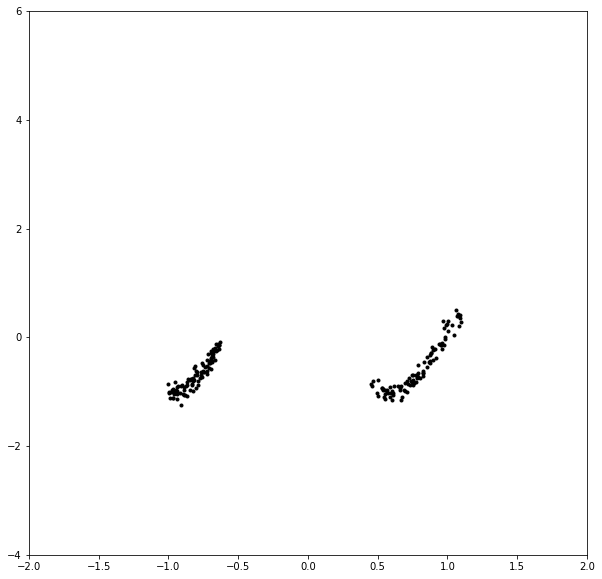

[Epoch 40/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


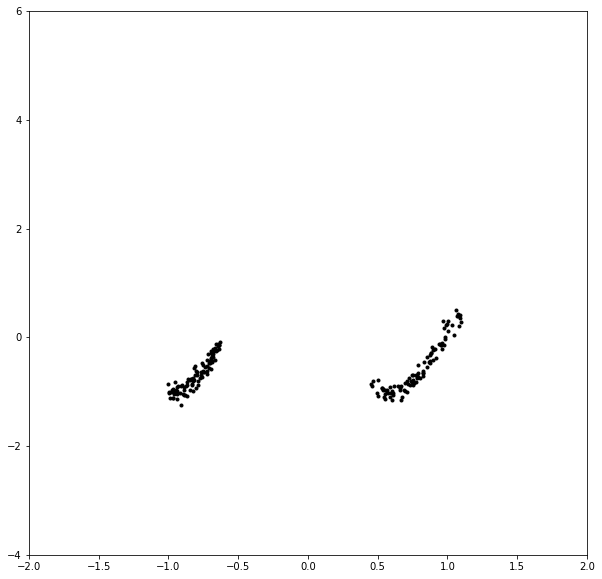

[Epoch 41/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


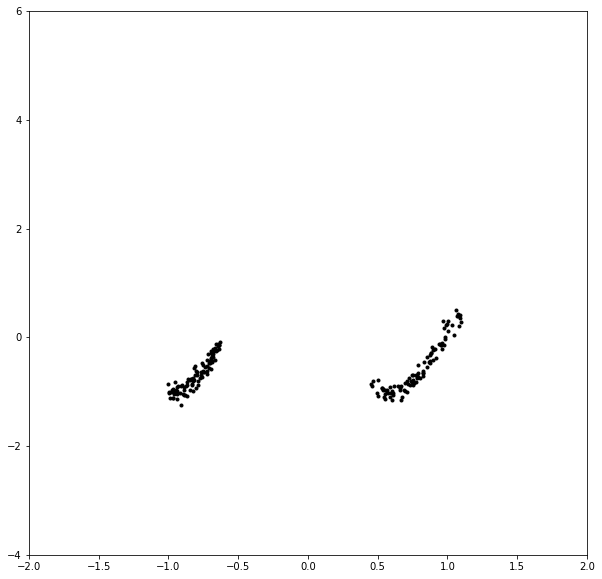

[Epoch 42/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


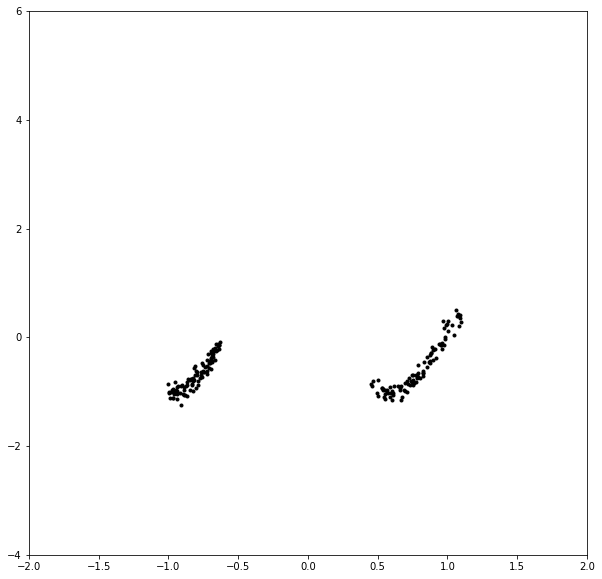

[Epoch 43/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


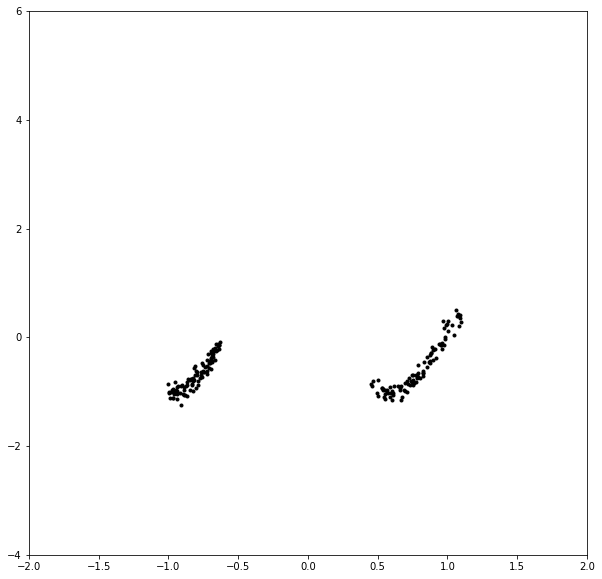

[Epoch 44/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


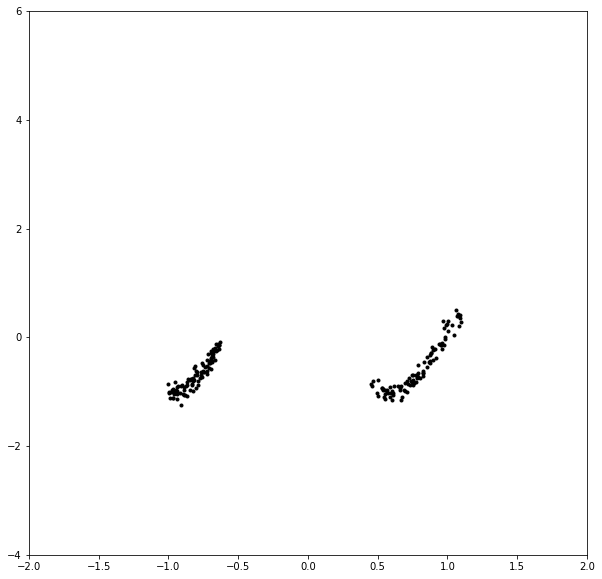

[Epoch 45/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


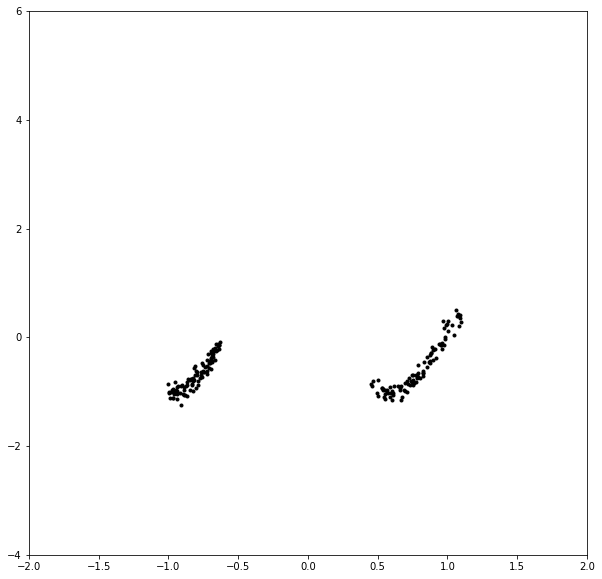

[Epoch 46/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


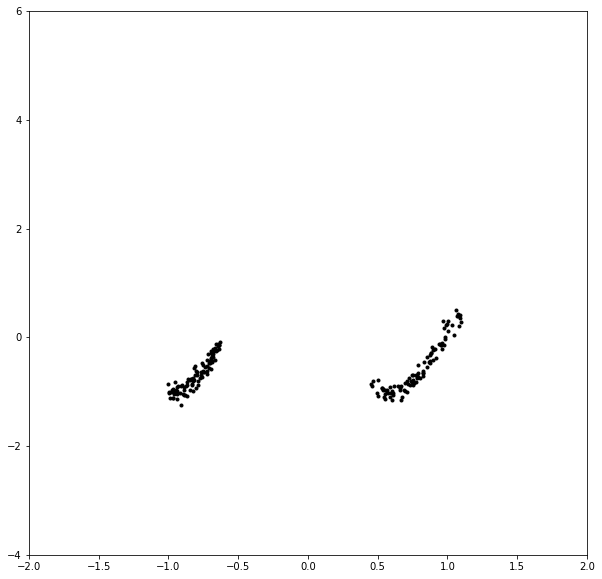

[Epoch 47/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


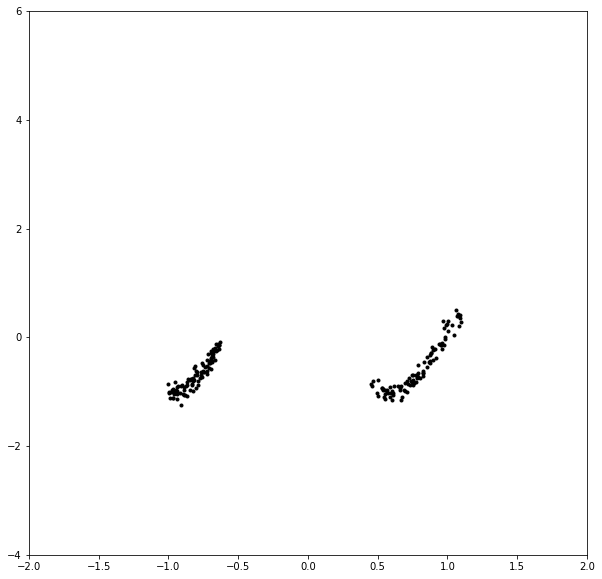

[Epoch 48/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


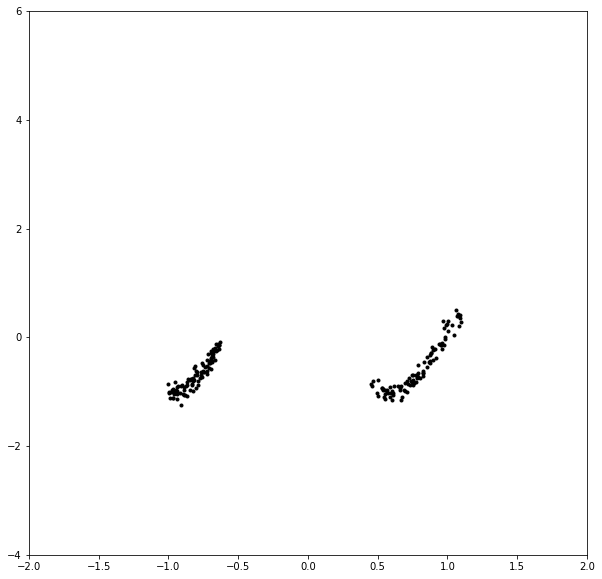

[Epoch 49/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


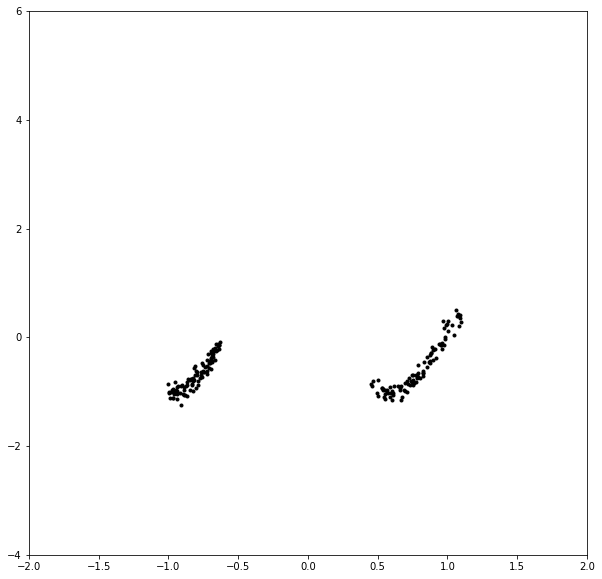

[Epoch 50/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


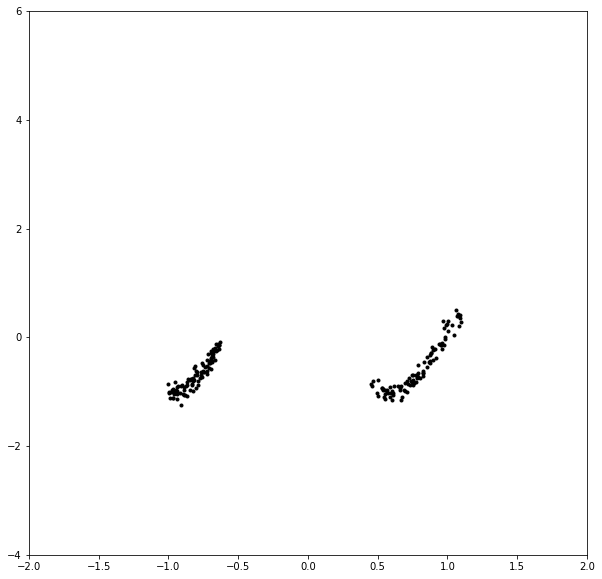

[Epoch 51/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


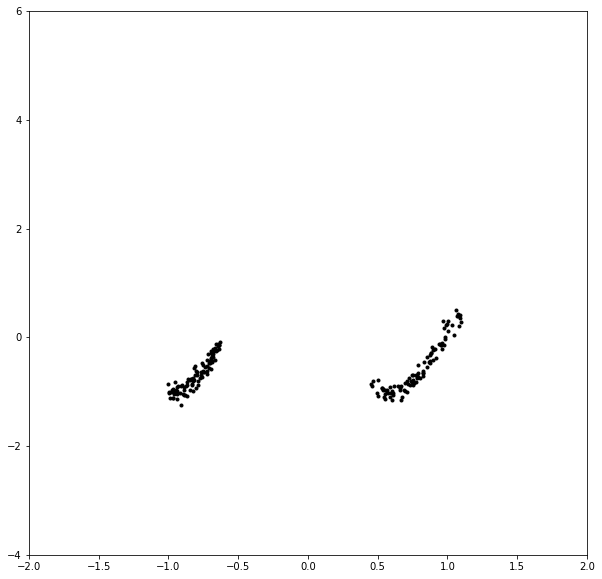

[Epoch 52/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


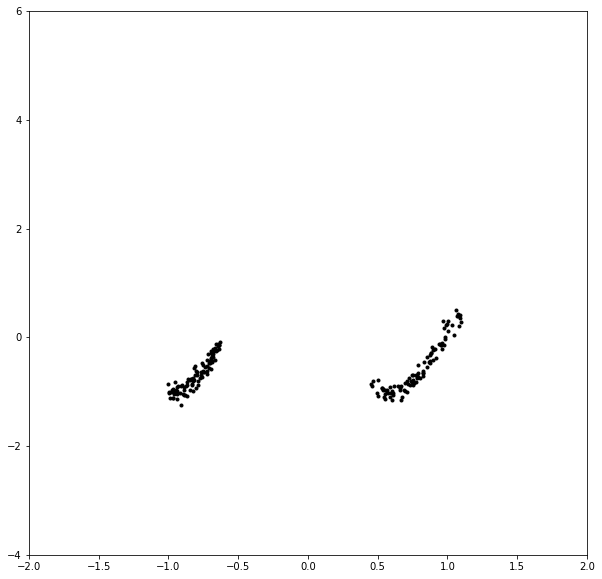

[Epoch 53/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


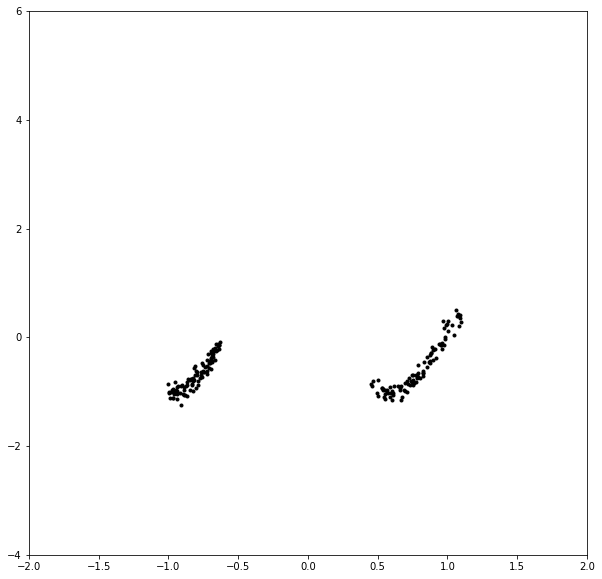

[Epoch 54/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


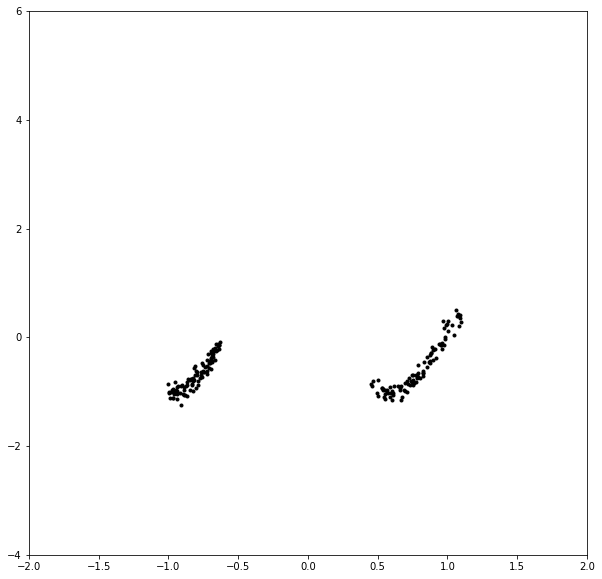

[Epoch 55/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


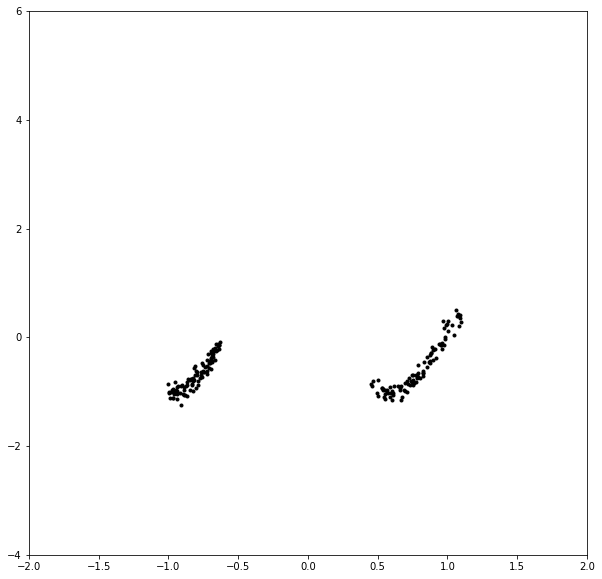

[Epoch 56/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


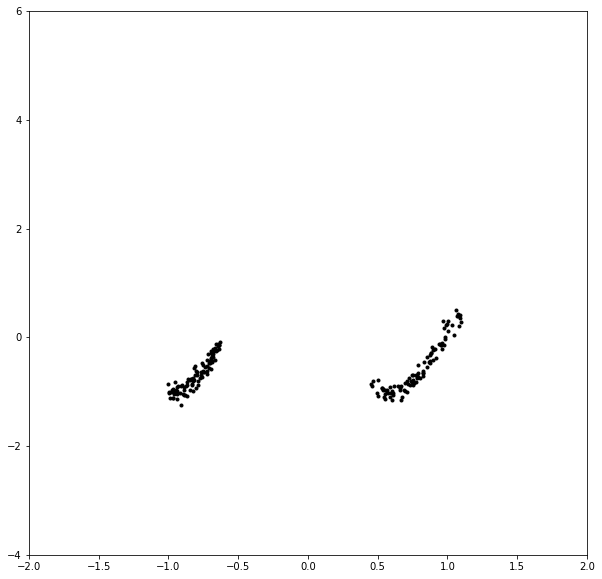

[Epoch 57/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


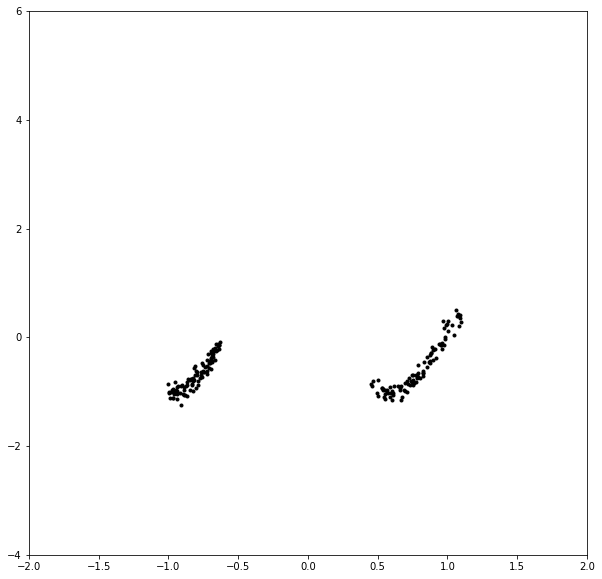

[Epoch 58/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


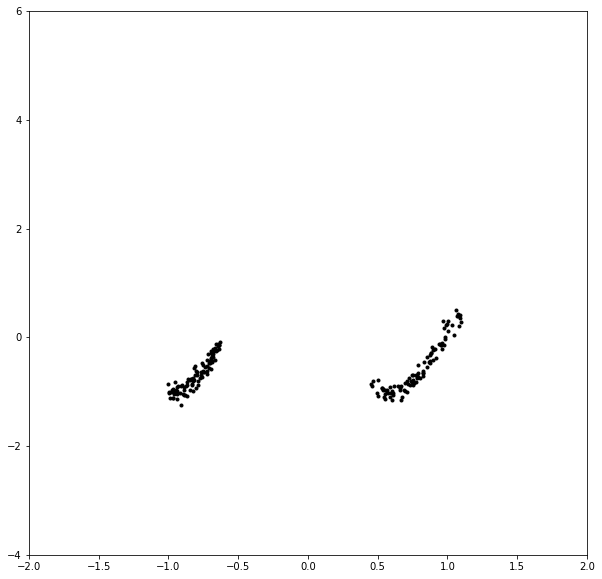

[Epoch 59/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


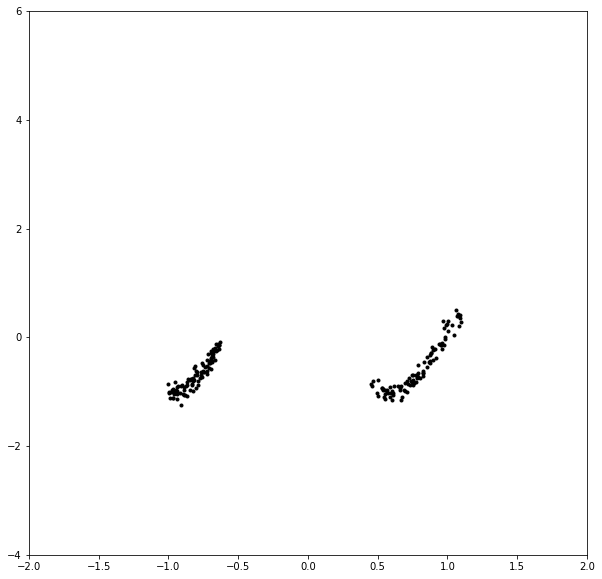

[Epoch 60/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


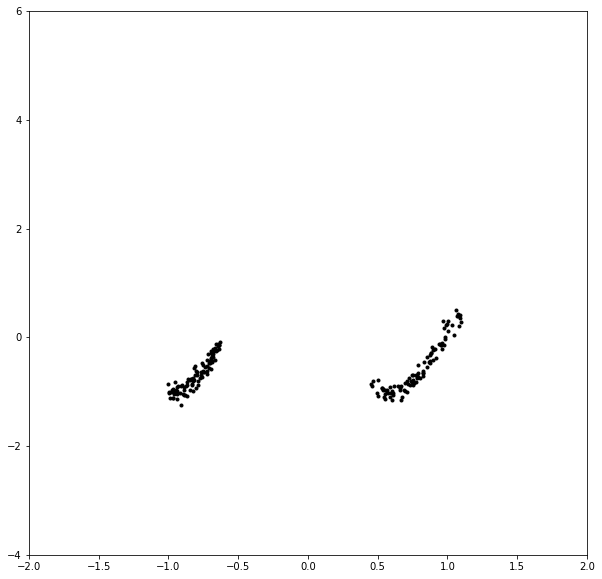

[Epoch 61/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


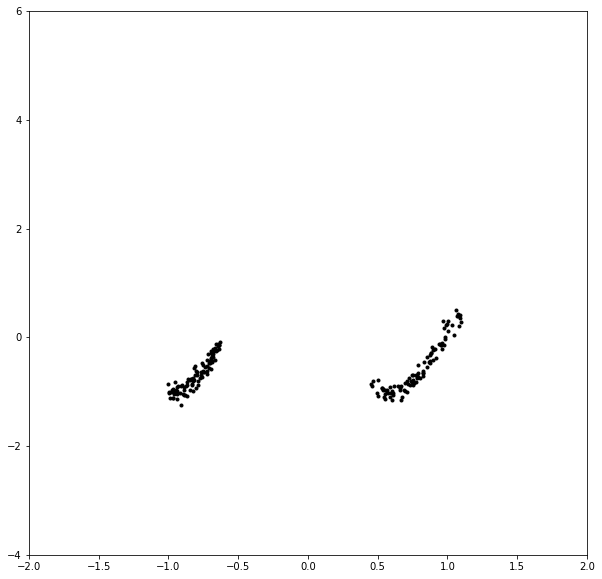

[Epoch 62/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


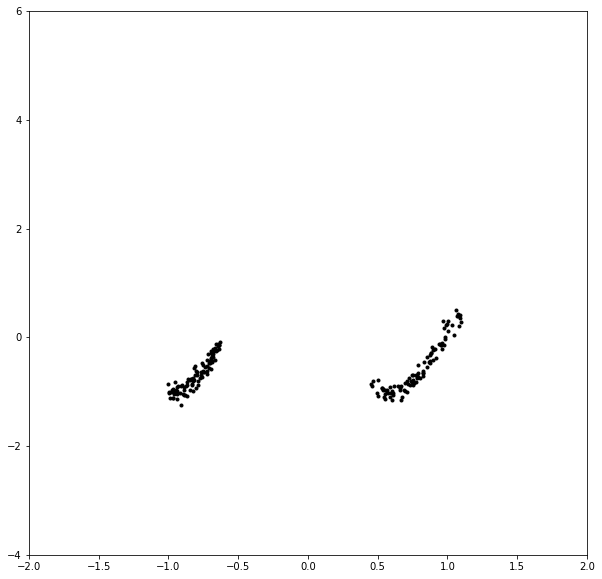

[Epoch 63/20000] [D loss: nan] [G loss: 45.616173]


<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/yann/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


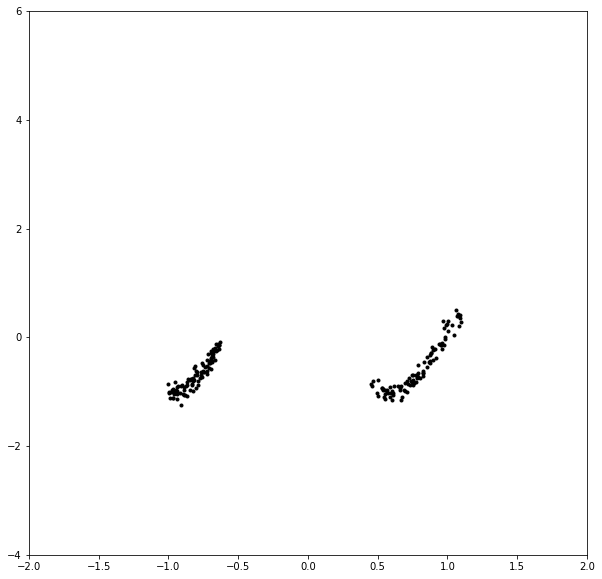

[Epoch 64/20000] [D loss: nan] [G loss: 45.616173]


KeyboardInterrupt: 

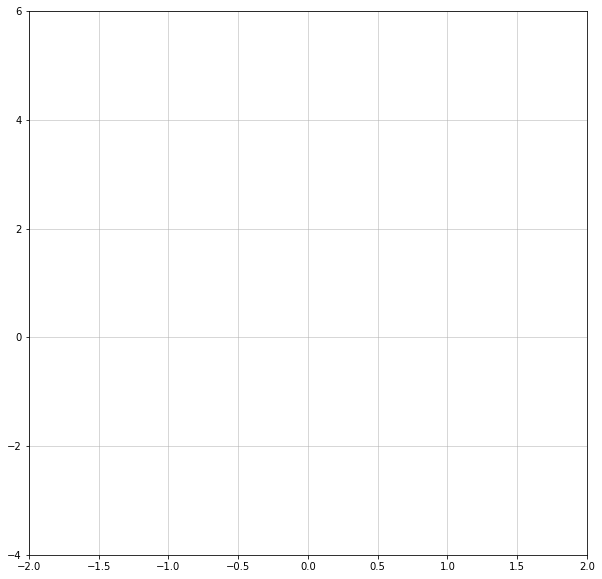

In [12]:
# ----------
#  Training
# ----------

n_epochs=20000

n_critic=1000

lambda_gp_X=.1
lambda_gp_y=.1

for epoch in range(n_epochs):

    # Configure input
    real_X, real_y =X_train, y_train
    
    n_fake_samples=500#X_train.shape[0]

    # ---------------------
    #  Train Discriminator
    # ---------------------

    optimizer_D.zero_grad()

    # Sample noise as generator input
    n_fake_samples=X_train.shape[0]
    z = Tensor(np.random.normal(0, 1, (n_fake_samples, lat_dim)))

    # Generate a batch of paramters
    fake_params = generator(z)

    # Generate a batch of inputs in [-2,2]
    fake_X=Tensor(-2.+4.*np.random.random((n_fake_samples, 1)))
    
    #Generate a batch of fake targets corresponding to fake inputs
    fake_X, fake_y=fake_X, torch.diag(prediction(fake_X,fake_params)).unsqueeze(-1)
    
    
    # Real images
    real_validity = discriminator(real_X,real_y)
    # Fake images
    fake_validity = discriminator(fake_X,fake_y)
    # Gradient penalty
    #gradient_penalty_X,gradient_penalty_y  = compute_gradient_penalty(discriminator, real_X, real_y, fake_X,fake_y)
    #norm_penalty  = compute_norm_penalty(discriminator, real_X, real_y, fake_X,fake_y)
    grad_penalty_X,grad_penalty_y  = compute_gradient_penalty(discriminator, real_X, real_y, fake_X,fake_y)
    # Adversarial loss
    d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)+lambda_gp_X*grad_penalty_X +lambda_gp_y*grad_penalty_y#+norm_penalty 
    #+lambda_NP * grad_penalty_X# +lambda_y * gradient_penalty_y
    d_loss.backward()
    optimizer_D.step()

    optimizer_G.zero_grad()



    
    # Train the generator every n_critic steps
    if epoch % n_critic == 0:

        # -----------------
        #  Train Generator
        # -----------------

        
         # Sample noise as generator input
        n_fake_samples=500
        z = Tensor(np.random.normal(0, 1, (n_fake_samples, lat_dim)))

        # Generate a batch of paramters
        fake_params = generator(z)

        # Generate a batch of inputs
        fake_X=real_X#Tensor(-2.+4.*np.random.random((n_fake_samples, 1)))

        #Generate a batch of fake targets corresponding to fake inputs
        fake_X, fake_y=fake_X, torch.diag(prediction(fake_X,fake_params)).unsqueeze(-1)

        #generate batch of points from parameter prior N(0,1)
        # Generate a batch of paramters
        prior_params = Tensor(np.random.normal(0, 1, (n_fake_samples, param_count)))
        
        # Train on fake images
        fake_validity = discriminator(fake_X,fake_y)
        g_loss = -torch.mean(fake_validity)+.1*KL(fake_params, prior_params,k=4,device=device)#.1*NNE(projection(fake_params,1),1,device)

        g_loss.backward()
        optimizer_G.step()

    if epoch % 1 == 0:
        show(generator,discriminator, 200, fake_X.cpu(),fake_y.detach().cpu())
        #plt.close()
        #show(generator,discriminator, 0)
        print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, d_loss.item(), g_loss.item())
            )

    

    

In [ ]:
show(generator,discriminator, 0)

In [ ]:
z = Tensor(np.random.normal(0, 1, (1000, lat_dim)))
theta=generator(z)

fig=setup.makePlot(theta,device)
plt.draw()

In [ ]:
show(generator,discriminator, 1000)

Distributions de paramètres: $H(w)$ et $G(W)$

Supposons un likelihood: p(y|X,W)

Distribution prédictive, pour chaque X distribution
$$
p^H_X(y)=\int p(y|X,W) dH(W)
$$
et 
$$
p^G_X(y)=\int p(y|X,W) dG(W)
$$

Si pour tous $X$ et $y$ on a $p^H_X(y)=p^G_X(y)$, on a pas nécessairement $H=G$.


$$
d(H,G)=E_{X}[KL(p^H_X||p^G_X)]
$$